# Part 1: setup

#### Import libraries

In [2]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Import dataset

In [17]:
url20 = "https://zenodo.org/records/8303397/files/full_data_20.csv?download=1"

gamesAt20 = pd.read_csv(url20 , sep=',')

backup = gamesAt20.copy()

In [200]:
# reset the dataset using backup

gamesAt20 = backup.copy()
backup

,Unnamed: 0,matchID,fullTimeMS,timePercent,blueChampionKill,blueFirstBlood,blueDragonKill,blueDragonHextechKill,blueDragonChemtechKill,blueDragonFireKill,...,redDragonElderKill,redRiftHeraldKill,redBaronKill,redTowerKill,redInhibitorKill,redTotalGold,redMinionsKilled,redJungleMinionsKilled,redAvgPlayerLevel,redWin
0,0,BR1_2720891721,2092233,6,5,True,0,0,0,0,...,0,0,0,0,0,8014,57,30,4.2,False
1,1,BR1_2720337066,1867984,6,1,False,0,0,0,0,...,0,0,0,0,0,9018,91,40,4.8,True
2,2,BR1_2720218416,2396948,7,3,False,0,0,0,0,...,0,0,0,0,0,9085,94,36,5.0,False
3,3,BR1_2720199652,1656791,5,2,True,0,0,0,0,...,0,0,0,0,0,7220,91,20,4.4,False
4,4,BR1_2720058177,1875549,6,2,False,0,0,0,0,...,0,0,0,0,0,10378,83,36,4.8,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64551,16558,BR1_2720967880,1688653,5,1,False,0,0,0,0,...,0,0,0,0,0,7973,96,32,4.4,False
64552,16559,BR1_2731950687,1235453,4,0,False,0,0,0,0,...,0,0,0,0,0,6094,60,24,3.6,False
64553,16560,BR1_2731932982,1604355,5,3,True,0,0,0,0,...,0,0,0,0,0,6938,86,28,4.2,False
64554,16561,BR1_2731920865,1689825,5,1,False,0,0,0,0,...,0,0,0,0,0,9517,86,32,4.4,True


In [201]:
gamesAt20

,Unnamed: 0,matchID,fullTimeMS,timePercent,blueChampionKill,blueFirstBlood,blueDragonKill,blueDragonHextechKill,blueDragonChemtechKill,blueDragonFireKill,...,redDragonElderKill,redRiftHeraldKill,redBaronKill,redTowerKill,redInhibitorKill,redTotalGold,redMinionsKilled,redJungleMinionsKilled,redAvgPlayerLevel,redWin
0,0,BR1_2720891721,2092233,6,5,True,0,0,0,0,...,0,0,0,0,0,8014,57,30,4.2,False
1,1,BR1_2720337066,1867984,6,1,False,0,0,0,0,...,0,0,0,0,0,9018,91,40,4.8,True
2,2,BR1_2720218416,2396948,7,3,False,0,0,0,0,...,0,0,0,0,0,9085,94,36,5.0,False
3,3,BR1_2720199652,1656791,5,2,True,0,0,0,0,...,0,0,0,0,0,7220,91,20,4.4,False
4,4,BR1_2720058177,1875549,6,2,False,0,0,0,0,...,0,0,0,0,0,10378,83,36,4.8,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64551,16558,BR1_2720967880,1688653,5,1,False,0,0,0,0,...,0,0,0,0,0,7973,96,32,4.4,False
64552,16559,BR1_2731950687,1235453,4,0,False,0,0,0,0,...,0,0,0,0,0,6094,60,24,3.6,False
64553,16560,BR1_2731932982,1604355,5,3,True,0,0,0,0,...,0,0,0,0,0,6938,86,28,4.2,False
64554,16561,BR1_2731920865,1689825,5,1,False,0,0,0,0,...,0,0,0,0,0,9517,86,32,4.4,True


#### Check for empty cells

In [202]:
gamesAt20.isna().sum()

Unnamed: 0                 0
matchID                    0
fullTimeMS                 0
timePercent                0
blueChampionKill           0
blueFirstBlood             0
blueDragonKill             0
blueDragonHextechKill      0
blueDragonChemtechKill     0
blueDragonFireKill         0
blueDragonAirKill          0
blueDragonEarthKill        0
blueDragonWaterKill        0
blueDragonElderKill        0
blueRiftHeraldKill         0
blueBaronKill              0
blueTowerKill              0
blueInhibitorKill          0
blueTotalGold              0
blueMinionsKilled          0
blueJungleMinionsKilled    0
blueAvgPlayerLevel         0
blueWin                    0
redChampionKill            0
redFirstBlood              0
redDragonKill              0
redDragonHextechKill       0
redDragonChemtechKill      0
redDragonFireKill          0
redDragonAirKill           0
redDragonEarthKill         0
redDragonWaterKill         0
redDragonElderKill         0
redRiftHeraldKill          0
redBaronKill  

In [203]:
(gamesAt20.values == '?').sum()

0

# Part 2: Clean the data

### Unused data
There are 2 features we can remove easily. The features are matchID and Unnamed.
We believe that Unnamed is a index counter, matchID is self explanatory.

In [204]:
gamesAt20.drop(labels=['Unnamed: 0' , 'matchID'] , axis=1 , inplace=True)

### Redundant data
Boolean columns like red/blue first blood and red/blue win are boolean and redundant, if one is true for red then it must be false for blue.
Moving forward we will drop red team boolean variables

In [205]:
gamesAt20['blueFirstBlood'] = gamesAt20['blueFirstBlood'].astype(int)
gamesAt20['blueWin'] = gamesAt20['blueWin'].astype(int)

gamesAt20.drop(labels=['redFirstBlood' , 'redWin'] , axis=1 , inplace=True)

### Extreme edge cases  

Furthermore since we are only at 20% of the game it is nearly impossible that inhibitors and towers have been destroyed, therefore we can safely remove them.
More features we can safely remove are baron kills and elder kills since baron spawns at 20 minutes, and the elder dragon spawns 5 minutes after one team has claimed 4 dragons, and each dragon is on a 5 minute respawn timer. This means that at a minimum it takes 25 minutes for elder to spawn. For these values to be greater than 0 that means the game must last for over 100 minutes, and since the average game time is 25-45 minutes the 100 minute+ game is a clear outlier that we can discard.

In [206]:
gamesAt20.drop(labels=['blueBaronKill' , 'redBaronKill' , 'blueTowerKill' , 'redTowerKill' , 'blueDragonElderKill' , 'redDragonElderKill' , 'blueInhibitorKill' , 'redInhibitorKill'] , axis=1 , inplace=True)

### Inting, remakes, and FF

There are cases where a player may lave left the game early and the game can be "remade" or FF(forfeited) early, these games still have a win/loss outcome but we need to remove them since nothing actually happened in the game. To predict the outcome of these games is outside of the scope of this project.

There are cases where one or more players may be intentionally losing or a team may have just given up resulting in a FF, these games obviously need to be removed. This dataset lacks the features to properly detect inting but we can remove the games that are forfeited to remove enough of them.

To determine remade games we can simply compare the gold of each team, if they are the same then the game is remade. We will instead use a time cutoff since that will encompass the games with equal gold

In [207]:
# this is what we would have done to remove games that were known to be remakes
# gamesAt20.drop(gamesAt20[gamesAt20['blueTotalGold'] == gamesAt20['redTotalGold']].index , inplace=True)


To determine forfeited games we can cutoff all games that run for less than 17 minutes, 15 minutes is when the regular FF vote opens and we have 2 minute to allow for players to vote to end the game.
Let's look at a graph of the frequency of how long a game lasts.

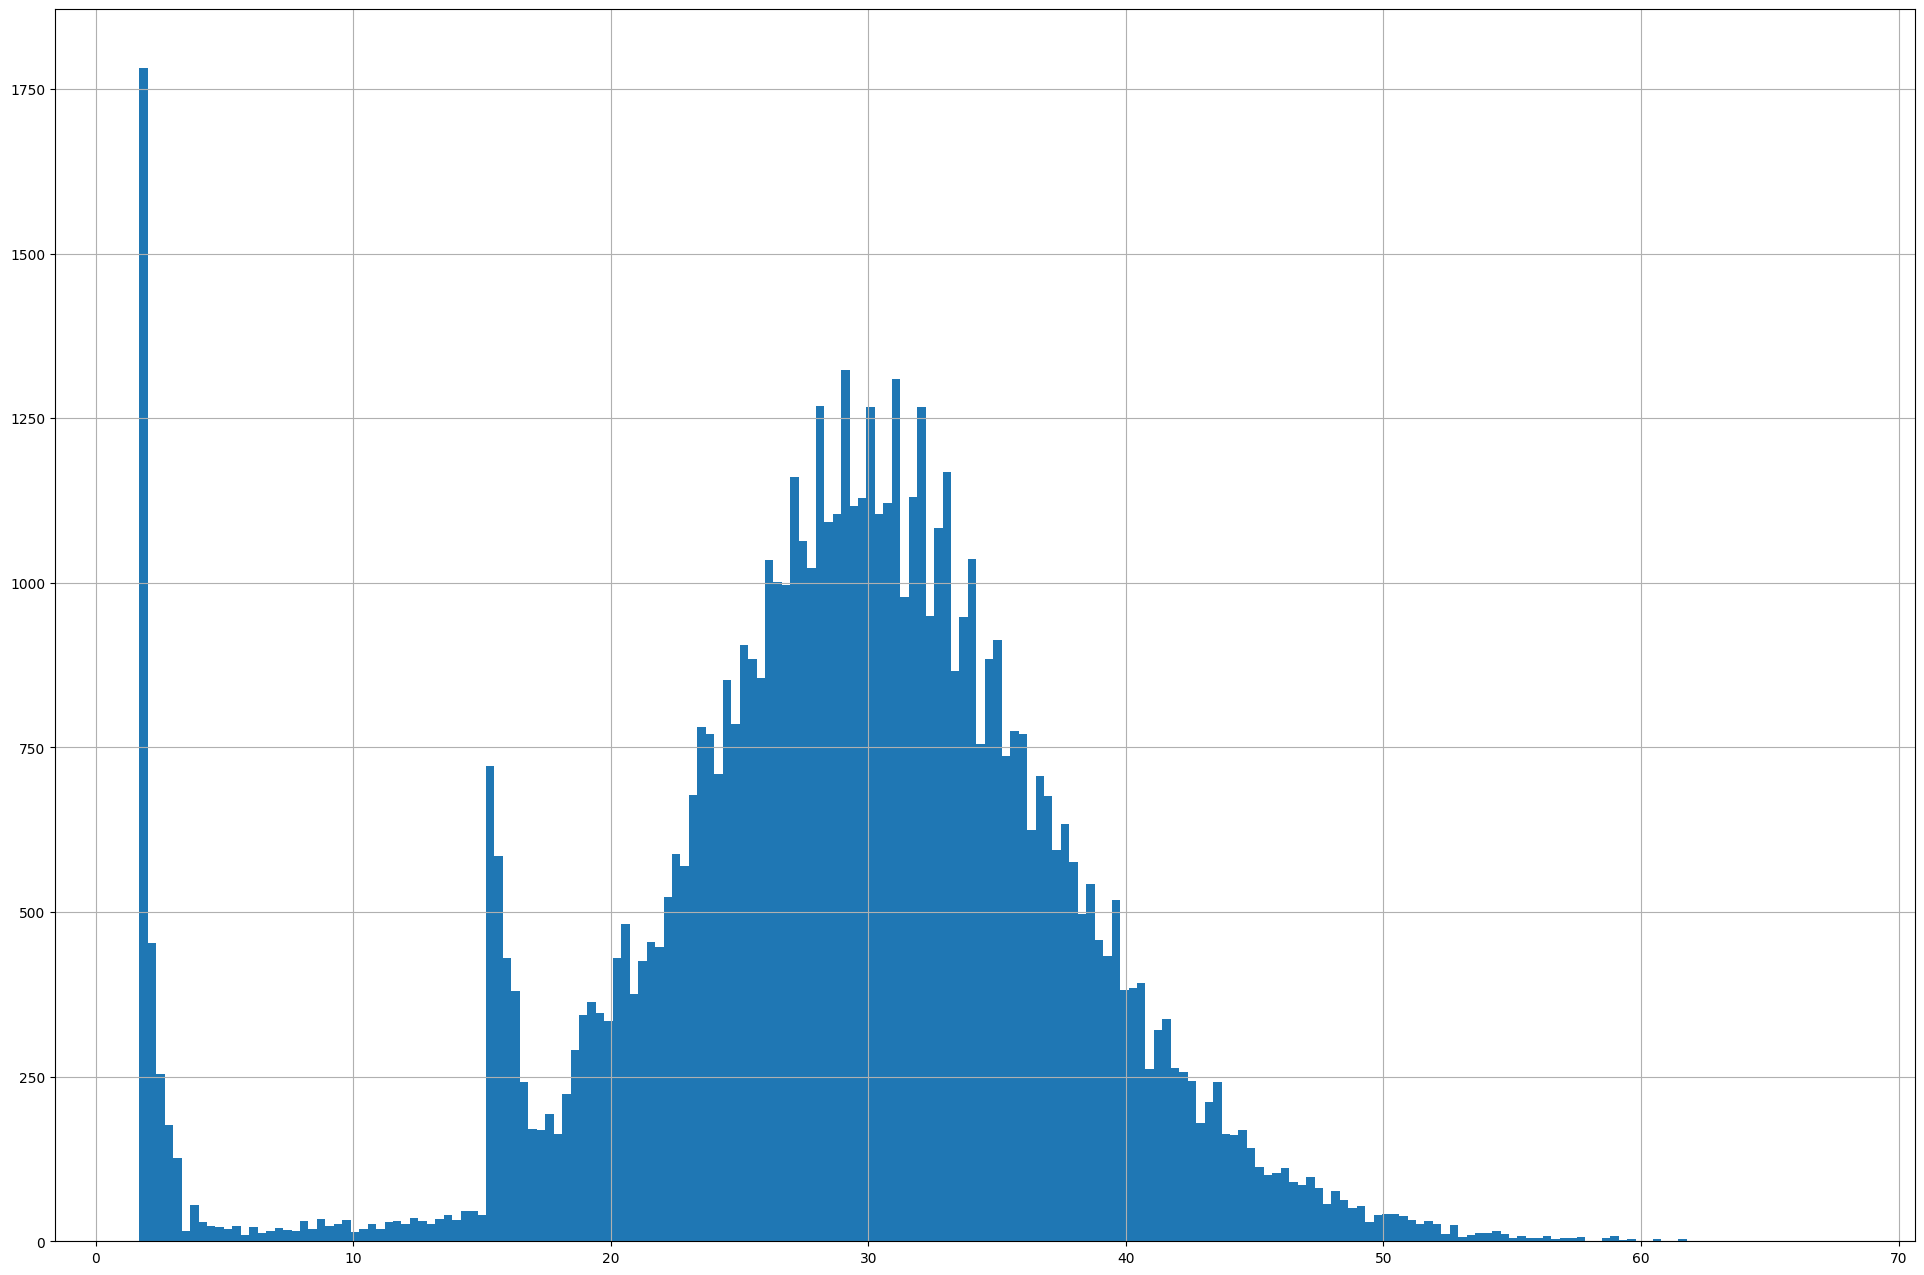

In [208]:
# add a column for the game time in minutes (for easier analysis)

gamesAt20['fullTimeMin'] = gamesAt20['fullTimeMS'] / 60000

# remove the time in MS
gamesAt20.drop(labels=['fullTimeMS'] , axis=1 , inplace=True)

# show the distribution of the game time

gamesAt20['fullTimeMin'].hist(bins = 200 , figsize=(24 , 16))
plt.show()

Notice there are two massive spikes from the distribution, the first one occurs before 5 minutes, these games are all remake. The second massive spike occurs just after 15 minutes, this is when the regular FF vote opens and games are forfeited. From this we can conclude every game before 17 minutes can be safely ignored.

In [209]:
gamesAt20.drop(gamesAt20[gamesAt20['fullTimeMin'] < 17].index , inplace=True)

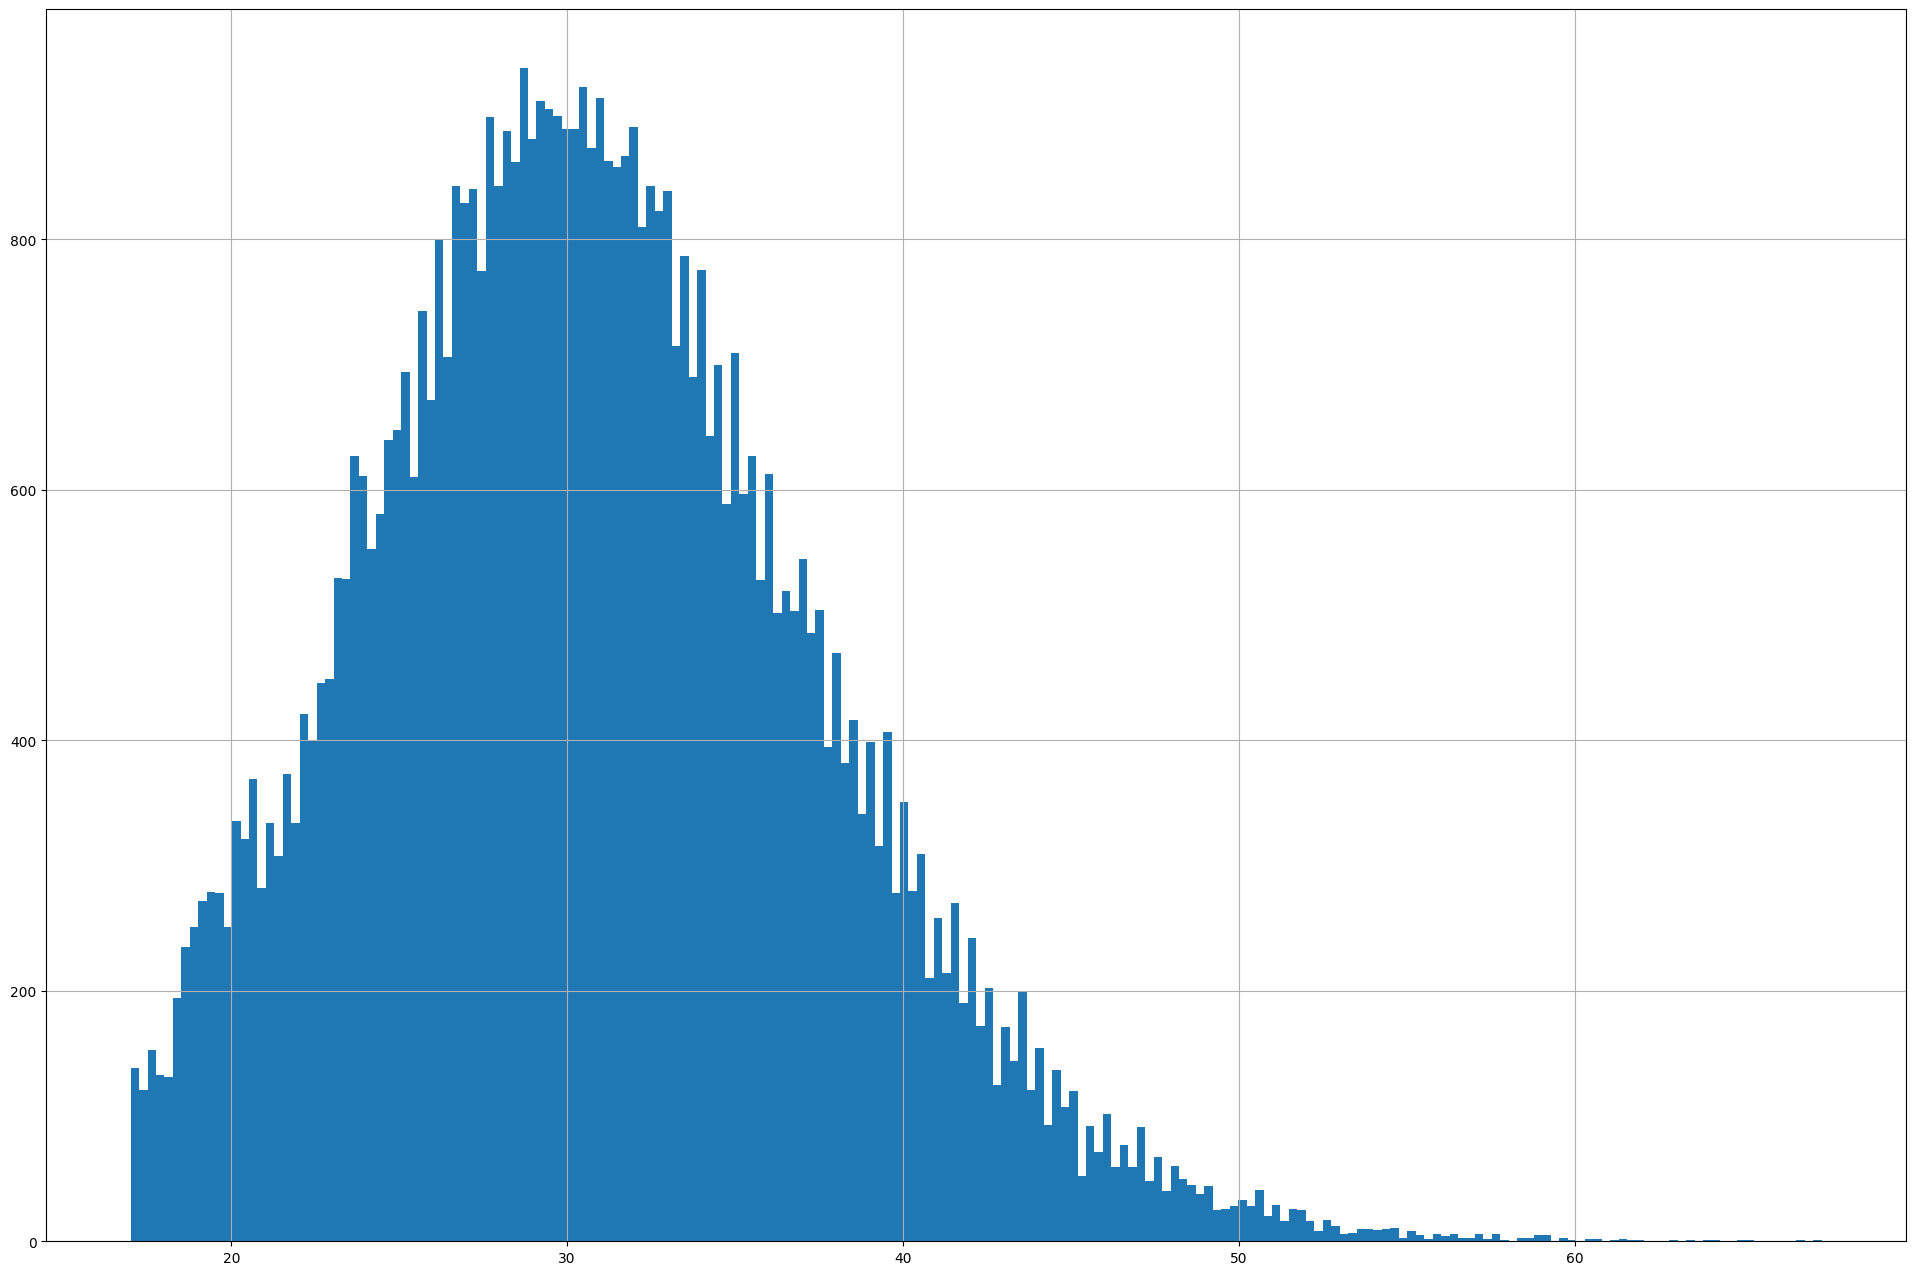

In [210]:
gamesAt20['fullTimeMin'].hist(bins = 200 , figsize=(24 , 16))
plt.show()

### Refined graphs

These graphs are much better, however some values are stull bound at either 1 or 0, most are regarding neutral objectives. At this point in the game it is highly unlikely that any neutral objective will have been claimed so we should be able to safely remove these data points, but we will determine how much the actually matter first.

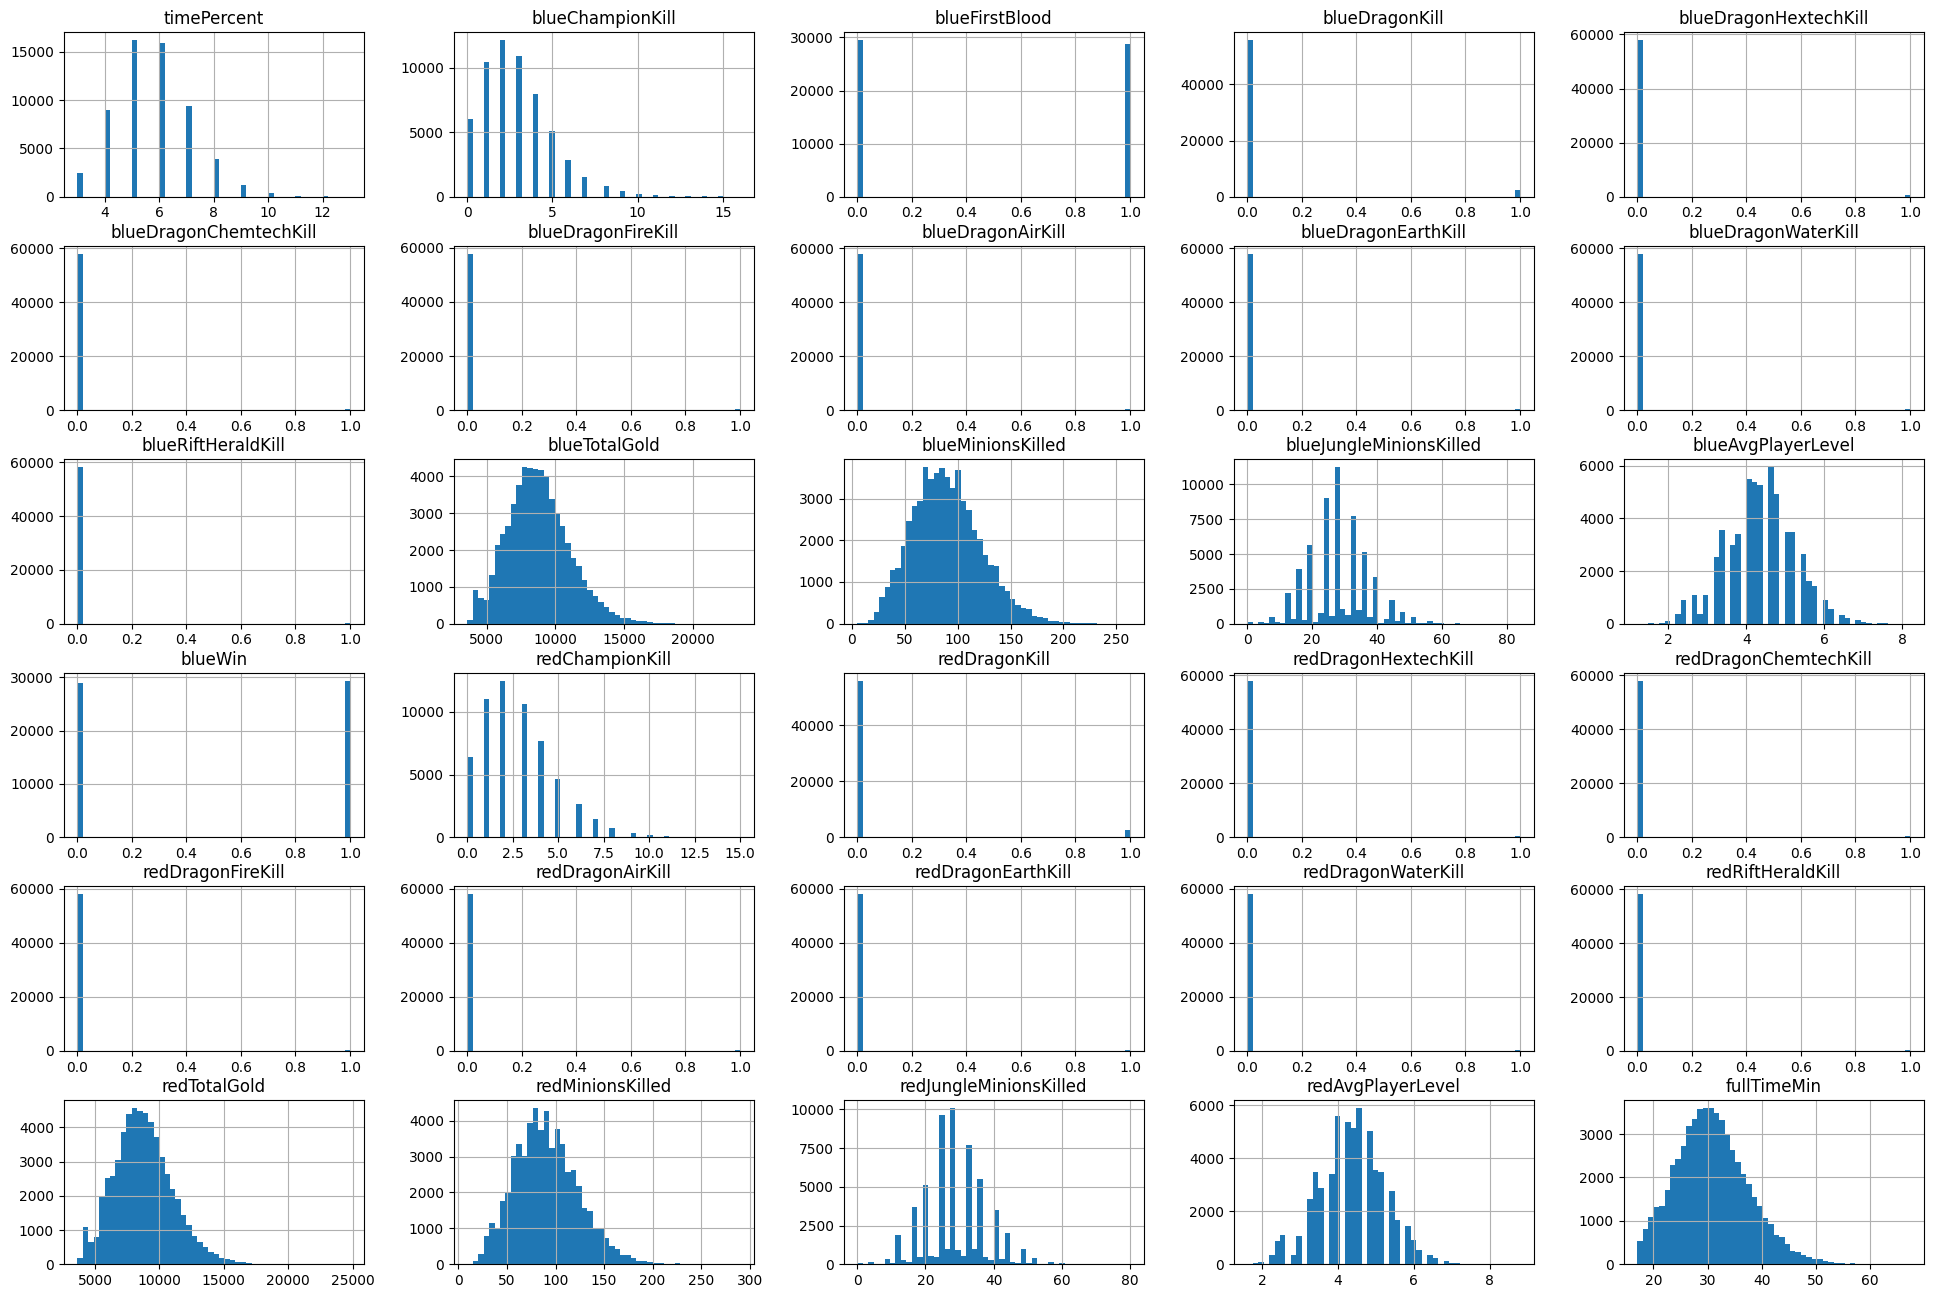

In [211]:
gamesAt20.hist(bins = 50 , figsize=(24 , 16))
plt.show()

#### Let's compare the importance of claiming a neutral objective (dragon or herald) versus the importance of the other features

Neutral objectives

In [212]:
# lets look at how many games blue team wins when they get the dragon or rift herald

blue_wins = gamesAt20[gamesAt20['blueWin'] == 1]
blue_wins_obj = blue_wins[(blue_wins['blueDragonKill'] > 0) | (blue_wins['blueRiftHeraldKill'] > 0)].shape[0]

# lets look at how many games red team wins when they get the dragon or rift herald

red_wins = gamesAt20[gamesAt20['blueWin'] == 0]
red_wins_obj = red_wins[(red_wins['redDragonKill'] > 0) | (red_wins['redRiftHeraldKill'] > 0)].shape[0]

print("blue wins: " + str(blue_wins.shape[0]))
print("blue wins with 1st obj: " + str(blue_wins_obj))
print("% won: " + str(blue_wins_obj / blue_wins.shape[0] * 100))

print("red wins: " + str(red_wins.shape[0]))
print("red wins with 1st obj: " + str(red_wins_obj))
print("% won: " + str(red_wins_obj / red_wins.shape[0] * 100))

blue wins: 29378
blue wins with 1st obj: 1395
% won: 4.748451222002859
red wins: 28966
red wins with 1st obj: 1399
% won: 4.829800455706691


First blood

In [213]:
# we can resuse the blue_wins and red_wins dataframes

blue_wins_FB = blue_wins[blue_wins['blueFirstBlood'] == 1].shape[0]
red_wins_FB = red_wins[red_wins['blueFirstBlood'] == 0].shape[0]

print("blue wins: " + str(blue_wins.shape[0]))
print("blue wins with 1st blood: " + str(blue_wins_FB))
print("% won: " + str(blue_wins_FB / blue_wins.shape[0] * 100))

print("red wins: " + str(red_wins.shape[0]))
print("red wins with 1st blood: " + str(red_wins_FB))
print("% won: " + str(red_wins_FB / red_wins.shape[0] * 100))

blue wins: 29378
blue wins with 1st blood: 16472
% won: 56.06916740418
red wins: 28966
red wins with 1st blood: 16601
% won: 57.312020990126356


Early game gold leads

In [214]:
blue_wins_GL = gamesAt20[(gamesAt20['blueTotalGold'] > gamesAt20['redTotalGold']) & (gamesAt20['blueWin'] == 1)].shape[0]
red_wins_GL = gamesAt20[(gamesAt20['redTotalGold'] > gamesAt20['blueTotalGold']) & (gamesAt20['blueWin'] == 0)].shape[0]

print("blue wins: " + str(blue_wins.shape[0]))
print("blue wins with more gold: " + str(blue_wins_GL))
print("% won: " + str(blue_wins_GL / blue_wins.shape[0] * 100))

print("red wins: " + str(red_wins.shape[0]))
print("red wins with more gold: " + str(red_wins_GL))
print("% won: " + str(red_wins_GL / red_wins.shape[0] * 100))

blue wins: 29378
blue wins with more gold: 18141
% won: 61.75028933215331
red wins: 28966
red wins with more gold: 17726
% won: 61.19588483049092


Early game level leads

In [215]:
blue_wins_LL = blue_wins[(blue_wins['blueAvgPlayerLevel'] > blue_wins['redAvgPlayerLevel'])].shape[0]
red_wins_LL = red_wins[(red_wins['redAvgPlayerLevel'] > red_wins['blueAvgPlayerLevel'])].shape[0]

print("blue wins: " + str(blue_wins.shape[0]))
print("blue wins with higher avg player level: " + str(blue_wins_LL))
print("% won: " + str(blue_wins_LL / blue_wins.shape[0] * 100))

print("red wins: " + str(red_wins.shape[0]))
print("red wins with higher avg player level: " + str(red_wins_LL))
print("% won: " + str(red_wins_LL / red_wins.shape[0] * 100))

blue wins: 29378
blue wins with higher avg player level: 12298
% won: 41.861256722717684
red wins: 28966
red wins with higher avg player level: 13034
% won: 44.99758337361044


Early game kills

In [216]:
blue_wins_K = blue_wins[(blue_wins['blueChampionKill'] > blue_wins['redChampionKill'])].shape[0]
red_wins_K = red_wins[(red_wins['redChampionKill'] > red_wins['blueChampionKill'])].shape[0]

print("blue wins: " + str(blue_wins.shape[0]))
print("blue wins with more kills: " + str(blue_wins_K))
print("% won: " + str(blue_wins_K / blue_wins.shape[0] * 100))

print("red wins: " + str(red_wins.shape[0]))
print("red wins with more kills: " + str(red_wins_K))
print("% won: " + str(red_wins_K / red_wins.shape[0] * 100))

blue wins: 29378
blue wins with more kills: 15062
% won: 51.269657566886785
red wins: 28966
red wins with more kills: 13791
% won: 47.610992197749084


Early game jungle impact

In [217]:
blue_wins_Jg_lead = gamesAt20[(gamesAt20['blueJungleMinionsKilled'] > gamesAt20['redJungleMinionsKilled']) & (gamesAt20['blueWin'] == 1)].shape[0]
red_wins_Jg_lead = gamesAt20[(gamesAt20['redJungleMinionsKilled'] > gamesAt20['blueJungleMinionsKilled']) & (gamesAt20['blueWin'] == 0)].shape[0]

print("blue wins: " + str(blue_wins.shape[0]))
print("blue wins with more jungle minions killed: " + str(blue_wins_Jg_lead))
print("% won: " + str(blue_wins_Jg_lead / blue_wins.shape[0] * 100))

print("red wins: " + str(red_wins.shape[0]))
print("red wins with more jungle minions killed: " + str(red_wins_Jg_lead))
print("% won: " + str(red_wins_Jg_lead / red_wins.shape[0] * 100))

blue wins: 29378
blue wins with more jungle minions killed: 12721
% won: 43.30110967390564
red wins: 28966
red wins with more jungle minions killed: 13821
% won: 47.714561900158806


Early game lane minions

In [218]:
blue_wins_LM = blue_wins[(blue_wins['blueMinionsKilled'] > blue_wins['redMinionsKilled'])].shape[0]
red_wins_LM = red_wins[(red_wins['redMinionsKilled'] > red_wins['blueMinionsKilled'])].shape[0]

print("blue wins: " + str(blue_wins.shape[0])) 
print("blue wins with more minions killed: " + str(blue_wins_LM))
print("% won: " + str(blue_wins_LM / blue_wins.shape[0] * 100))

print("red wins: " + str(red_wins.shape[0]))
print("red wins with more minions killed: " + str(red_wins_LM))
print("% won: " + str(red_wins_LM / red_wins.shape[0] * 100))

blue wins: 29378
blue wins with more minions killed: 15700
% won: 53.44135067056981
red wins: 28966
red wins with more minions killed: 16627
% won: 57.40178139888145


We can see that the first neutral objective has a negligible impact on the game outcome when compared to the other metrics. This means that we can at least remove the features that describe the type of dragon, since that would have an even smaller impact since the 4% comes from any neutral objective.

In [219]:
gamesAt20.drop(labels=['blueDragonHextechKill' , 'blueDragonChemtechKill' , 'blueDragonFireKill' , 'blueDragonAirKill' , 'blueDragonEarthKill' , 'blueDragonWaterKill'] , axis=1 , inplace=True)
gamesAt20.drop(labels=['redDragonHextechKill' , 'redDragonChemtechKill' , 'redDragonFireKill' , 'redDragonAirKill' , 'redDragonEarthKill' , 'redDragonWaterKill'] , axis=1 , inplace=True)

#### Here are updated graphs

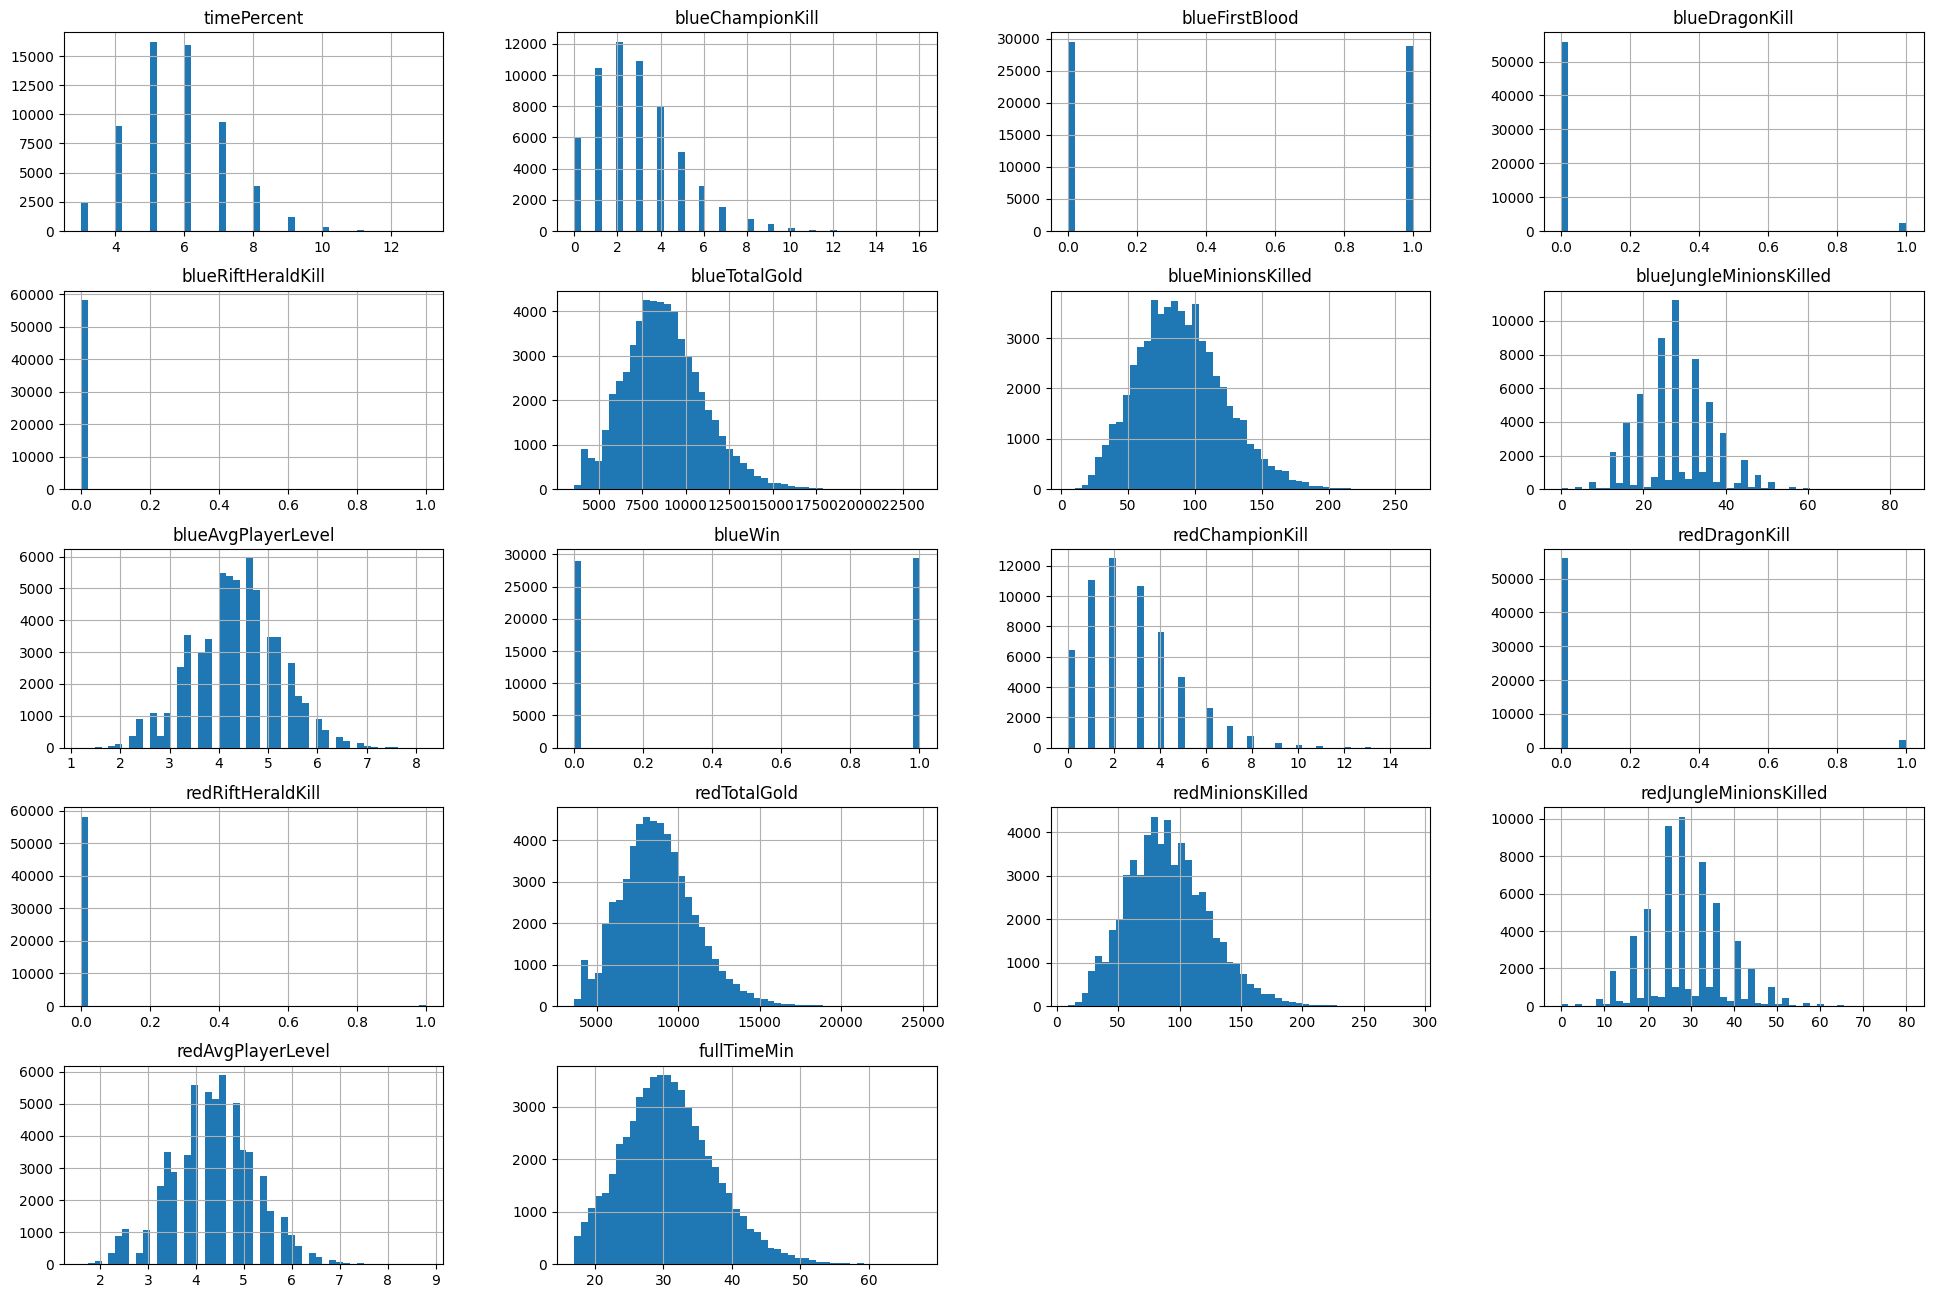

In [220]:
gamesAt20.hist(bins = 50 , figsize=(24 , 16))
plt.show()

#### Remove fullTimeMin and timePercent

These two features are for user reference only, fullTimeMin was used to determine a cutoff point and now that we are done with it we do not need it anymore.

In [221]:
gamesAt20.drop(labels=['timePercent' , 'fullTimeMin'] , axis=1 , inplace=True)

# Part 3: Select and train a model

### Split the dataset into training and testing sets

In [222]:
from sklearn.model_selection import train_test_split

x = gamesAt20.drop(labels=['blueWin'] , axis=1)
y = gamesAt20['blueWin']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print(x_train.shape , y_train.shape , x_test.shape , y_test.shape)

(46675, 15) (46675,) (11669, 15) (11669,)


## Regression (junk)

### Train a Linear Regression model

In [223]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(x_train , y_train)

LinearRegression()

#### Test the model and report the MSE

In [224]:
lr_y_pred = lr_model.predict(x_test)

from sklearn.metrics import mean_squared_error as mse
lr_mse = mse(y_test , lr_y_pred)
lr_mse

0.23311278461917678

#### Plot the prediction versus the actual data

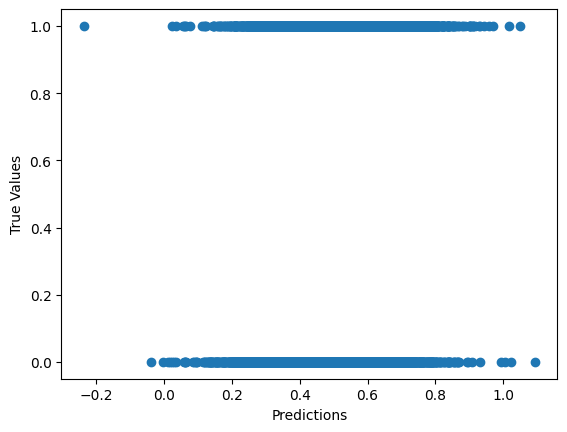

In [225]:
import matplotlib.pyplot as plt

plt.scatter( lr_y_pred , y_test)
plt.ylabel('True Values')
plt.xlabel('Predictions')
plt.show()

### Train a Linear Regression model using Ridge and lasso regularization with alpha = different values

In [226]:
from sklearn.linear_model import LinearRegression , Ridge , Lasso

RidgeRegress = Ridge(alpha=1)
ridge_model = RidgeRegress.fit(x_train , y_train)

LassoRegress = Lasso(alpha=1)
lasso_model = LassoRegress.fit(x_train , y_train)

#### Test the model

In [227]:
Ridge_y_pred = ridge_model.predict(x_test)
Lasso_y_pred = lasso_model.predict(x_test)
ridge_mse = mse(y_test , Ridge_y_pred)
lasso_mse = mse(y_test , Lasso_y_pred)

print(ridge_mse , lasso_mse)

0.23311255715881454 0.23461232230928547


### Plot the prediction versus the actual data

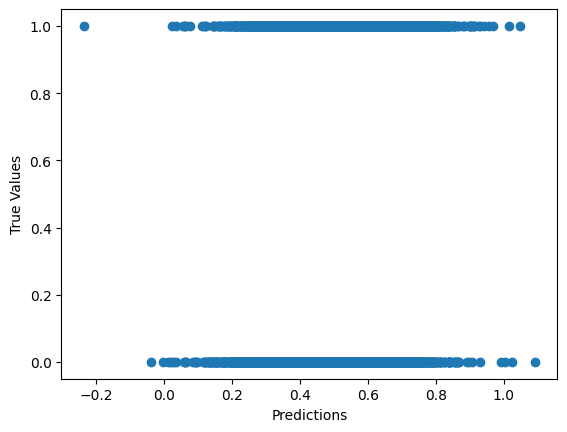

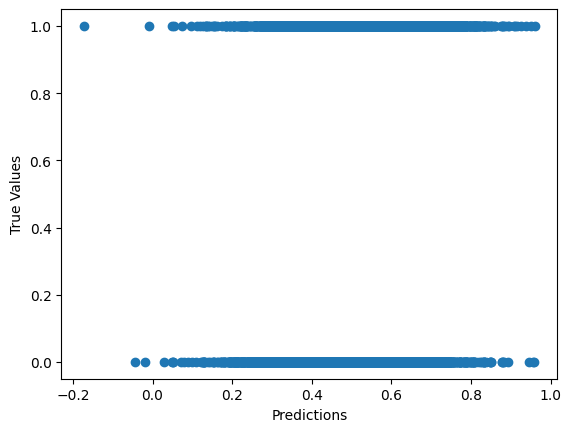

In [228]:
import matplotlib.pyplot as plt

plt.scatter( Ridge_y_pred , y_test)
plt.ylabel('True Values')
plt.xlabel('Predictions')
plt.show()

plt.scatter( Lasso_y_pred , y_test)
plt.ylabel('True Values')
plt.xlabel('Predictions')
plt.show()

## Classification

### SVM Classifier - SVC - Default Hyperparameters

#### Train the model

In [233]:
from sklearn.svm import SVC

poly_svc = SVC()
poly_svc.fit(x_train , y_train)

SVC()

#### Test the model

In [234]:
from sklearn.metrics import accuracy_score , confusion_matrix , classification_report

poly_y_pred = poly_svc.predict(x_test)
print(classification_report(y_test , poly_y_pred))

              precision    recall  f1-score   support

           0       0.61      0.61      0.61      5725
           1       0.63      0.62      0.62      5944

    accuracy                           0.62     11669
   macro avg       0.62      0.62      0.62     11669
weighted avg       0.62      0.62      0.62     11669



#### Performance Metrics

purple is bad

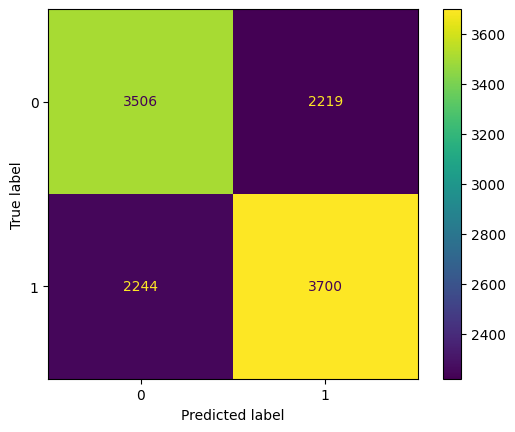

In [236]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test , poly_y_pred)
plt.show()